Importing libraries

In [20]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Plotting experimental EIS data

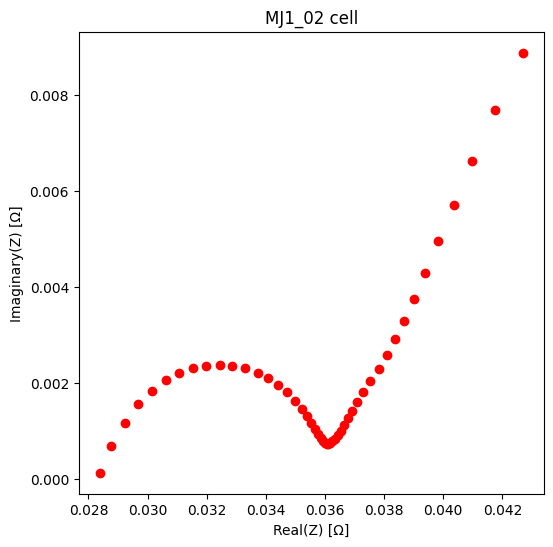

In [21]:
file = "/Users/synnemard/Desktop/lithium_ion/EIS data/MJ1_02.DTA"
# Information about the MJ1_02 cell: 
# ved BoL (Beginning of Life)
# ved ca. 45% SoC 
# ved 25 deg C

ca = Impedance(file)
ca.load(filename=file)

# process data header metadata to get start_time (not strictly necessary)
start_time = pd.Timestamp("{} {}".format(ca.header.get("DATE"), ca.header.get("TIME")))
    
# extract EIS curve
res = ca.get_curve_data()
res_reverse = res.iloc[::-1] #not necessary
df_mag = res_reverse['Zmod']
df_phz = res_reverse['Zphz']
df_real = res_reverse['Zreal']
df_imag= res_reverse['Zimag']
freq = res_reverse['Freq']

# excluding the values in the 4th quadrant: 
df_mag = df_mag[:49]
df_phz = df_phz[:49]
df_real = df_real[:49]
df_imag = df_imag[:49]
freq = freq[:49]

# Creating Nyquist plot
plt.figure(figsize=(6,6))
plt.scatter(df_real, -df_imag, color='red') 

# Labeling the plot
plt.xlabel('Real(Z) [Ω]')
plt.ylabel('Imaginary(Z) [Ω]')
plt.title('MJ1_02 cell')

#finner høyeste log frekvens 
x = np.log10(freq[22])

# Show plot
plt.show()


Defining parameters

In [22]:
# OCV curves for the anode and cathode
# Simple math model for the individual electrode potentials as a function of the stoichiometry of Lithium
def MJ1_ocp_tanh_SiC(sto):
    x = sto
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    
    return (
            p[0] * pybamm.exp(-p[1] * x)
            + p[2]
            - p[3] * pybamm.tanh(p[4] * (x - p[5]))
            - p[6] * pybamm.tanh(p[7] * (x - p[8]))
            - p[9] * pybamm.tanh(p[10] * (x - p[11]))
        )

def MJ1_ocp_tanh_NMC(sto):
    x = sto
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])

    return (
            -p[0] * x
            + p[1]
            - p[2] * pybamm.tanh(p[3] * (x - p[4]))
            - p[5] * pybamm.tanh(p[6] * (x - p[7]))
            + p[8] * pybamm.tanh(p[9] * (x - p[10]))
        )

# Parameters from literature
literature_params = {
    'Electrode height [m]': 0.059,
    'Electrode width [m]': 0.610*2, # Multiplying by two since the electrode has active material on both sides.
    'Lower voltage cut-off [V]': 2.5,
    'Upper voltage cut-off [V]': 4.5,
    'Nominal cell capacity [A.h]': 3.5,

    # From Table 3 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Maximum concentration in negative electrode [mol.m-3]': 32418.5,
    'Negative particle radius [m]': 6.1e-06,
    'Negative electrode porosity': 0.216,
    'Negative electrode active material volume fraction': 0.7011854763922494,
    'Negative electrode conductivity [S.m-1]': 100.0,
    'Negative electrode diffusivity [m2.s-1]': 5e-14,
    'Negative electrode OCP [V]': MJ1_ocp_tanh_SiC,

    # 'Maximum concentration in positive electrode [mol.m-3]': 51081.15,
    'Positive particle radius [m]': 3.8e-06,
    'Positive electrode porosity': 0.171,
    'Positive electrode active material volume fraction': 0.7355902286855152,
    'Positive electrode conductivity [S.m-1]': 0.17,
    'Positive electrode diffusivity [m2.s-1]': 5e-13,
    'Positive electrode OCP [V]': MJ1_ocp_tanh_NMC,

    'Separator porosity': 0.45,

    # end of section 3 data
    
    # From Table A-9 and A-10 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Negative current collector conductivity [S.m-1]': 5.9e7/(1+3.383e-3 * (298.15-293.15)), 
    'Negative current collector thickness [m]': 11e-06,
    'Negative current collector density [kg.m-3]': 8950.0,
    'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
    'Negative current collector thermal conductivity [W.m-1.K-1]': 398.0,
    'Negative electrode density [kg.m-3]': 2242.0,
    'Negative electrode specific heat capacity [J.kg-1.K-1]': 867.0,
    'Negative electrode thermal conductivity [W.m-1.K-1]': 1.04,
    'Negative electrode thickness [m]': 86.7e-6, # 86.7 in Sturm 2019, 85um in Heenan2020, 170um in NASA
    'Positive current collector conductivity [S.m-1]': 3.78e7/(1+4.290e-3 * (298.15-293.15)),
    'Positive current collector density [kg.m-3]': 2710.0,
    'Positive current collector specific heat capacity [J.kg-1.K-1]': 903.0,
    'Positive current collector thermal conductivity [W.m-1.K-1]': 238.0,
    'Positive current collector thickness [m]': 17.3e-06,
    'Positive electrode density [kg.m-3]': 4870.0,
    'Positive electrode specific heat capacity [J.kg-1.K-1]': 840.1,
    'Positive electrode thermal conductivity [W.m-1.K-1]': 1.58,
    'Positive electrode thickness [m]': 66.2e-6, #66.2um in Sturm2019, 72.5um in Heenan2020, 160um in NASA
    'Separator density [kg.m-3]': 1009.0,
    'Separator specific heat capacity [J.kg-1.K-1]': 1978.2,
    'Separator thermal conductivity [W.m-1.K-1]': 0.33,
    'Separator thickness [m]': 12e-06,
    # end of table data
    }

# Use default parameters from the Chen2020 publication
params = pybamm.ParameterValues("Chen2020")

# Overwrite parameters with our own
for parameter, value in literature_params.items():
    try:
        if params[parameter] != value: # Check if the parameter exists in 'params' and has a different value
            params[parameter] = value # Update 'params' with the new value from 'literature_params'
    except KeyError as e: # This block handles the case where the 'parameter' is not in 'params'
        print(f"Parameter {parameter} not part of default. Skipping.")

# Changing state of charge SOC
z = 0.45

x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(params)
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]

params.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

# Choosing the same frequency range as in the experimental plot. 
# x is ish equal to 2.8
frequencies = np.logspace(-2, 2.8, 49)



Optimization of ECM parameters

In [5]:
# Randles components parameters 
c_elem = {
    "R_el": 0.025763171661926085,  # Electrolyte resistance (Ohms)
    "L": 5.549209643415352e-07, # Inductance (H)
    
    #Cathode? 
    "R_ct1": 0.006417399825775271,  # Charge transfer resistance (Ohms)
    "C_dl1": 0.320907453,  # Double layer capacitance (Farads)
    "Q1" : 0.6755737998780649, 
    "alpha1": 0.6954407894299769, 
    "A1": 0.0021718928541864,     # Warburg coefficient
    "a_w1": 0.5845825436680924, 

    #Anode? 
    "R_ct2": 0.003800679024678755,  # Charge transfer resistance (Ohms)
    "C_dl2": 0.320907453,  # Double layer capacitance (Farads)
    "Q2" : 2.248615125484339, 
    "alpha2": 0.8212691811778315, 
    "A2": 0.027250693541684783,     # Warburg coefficient
    "a_w2": 0.74, 
    }


# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))


In [6]:
# Angular frequencies
ang_freq = 2*np.pi*frequencies

# Define Warburg impedance
def w_imp(omega, A):
    return A / np.sqrt(1j*omega)

def wni_imp(omega, A, a_w): # Non-Ideal 
    return A /(1j * omega)** a_w

# Define Capacitance impedance
def c_imp(omega, C): 
    return 1/(1j*omega*C)

# CPE for non-ideal behaviour
def cpe_imp(omega, Q, alpha): 
    return 1/(Q*(1j*omega)**alpha)

# Define Inductance impedance
def i_imp(omega, L): 
    return 1j*omega*L

# function for difference between the ECM model and the experimental values
def diff_func(comp, exp_real, exp_imag): 

    # Update c_elem dictionary from the flat parameter list (comp)
    c_elem_up = list_to_dict(c_elem, comp)

    Z_W1 = wni_imp(ang_freq, c_elem_up["A1"], c_elem_up["a_w1"])
    Z_cdl1 = cpe_imp(ang_freq, c_elem_up["Q1"], c_elem_up["alpha1"])
    Z_L = i_imp(ang_freq, c_elem_up["L"])

    Z_W2 = wni_imp(ang_freq, c_elem_up["A2"], c_elem_up["a_w2"])
    Z_cdl2 = cpe_imp(ang_freq, c_elem_up["Q2"], c_elem_up["alpha2"])

    Z1 =  1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    Z2 =  1/(1/(c_elem_up["R_ct2"]) + 1/Z_cdl2)
    Z = Z_L + c_elem_up["R_el"] + Z1 + Z2

    diff_real = Z.real - exp_real 
    diff_imag = Z.imag - exp_imag 
    sum_square_diff = np.sum(diff_real**2 + diff_imag**2)
    return sum_square_diff

# Convert initial dictionary to list for optimization
initial_elems = dict_to_list(c_elem)

options = {
    'maxiter': 10000,    # Maximum number of iterations
    'ftol': 1e-10,       # Function value tolerance
    #'disp': True         # Display convergence messages
}

# Minimize the difference function (optimize parameters)
opt = minimize(diff_func, initial_elems, args=(df_real, df_imag), method='TNC', options=options)

# Convert the optimized list back to dictionary
opt_elems = list_to_dict(c_elem, opt.x)

# Print the optimized elements
print("Optimized elements:", opt_elems)

# Print the difference after optimization
print("Final sum of squared difference:", diff_func(opt.x, df_real, df_imag))


Optimized elements: {'R_el': 0.025763749071968683, 'L': 5.547454018187025e-07, 'R_ct1': 0.006416160898001903, 'C_dl1': 0.320907453, 'Q1': 0.6755737702737263, 'alpha1': 0.6954406240400066, 'A1': 0.002172931231427539, 'a_w1': 0.5845822546368247, 'R_ct2': 0.0038011291135491717, 'C_dl2': 0.320907453, 'Q2': 2.2486151811094106, 'alpha2': 0.8212691701314082, 'A2': 0.027250693541684783, 'a_w2': 0.74}
Final sum of squared difference: 3.3242230294366167e-07


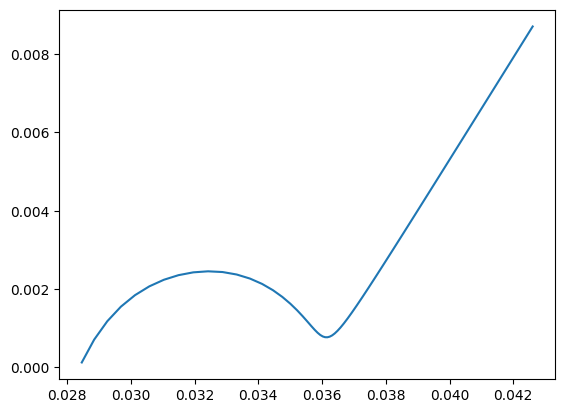

┌───────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Parameter                                                 │ Type of parameter                                                                                                                                                                                           │
├───────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Negative electrode Bruggeman coefficient (electrolyte)    │ Parameter                                                                                                                             

In [24]:
Z_W1 = wni_imp(ang_freq, opt_elems["A1"], opt_elems["a_w1"])
Z_cdl1 = cpe_imp(ang_freq, opt_elems["Q1"], opt_elems["alpha1"])
Z_L = i_imp(ang_freq, opt_elems["L"])

Z_W2 = wni_imp(ang_freq, opt_elems["A2"], opt_elems["a_w2"])
Z_cdl2 = cpe_imp(ang_freq, opt_elems["Q2"], opt_elems["alpha2"])

# Impedance from the Randles circuit 
def Z_randles(): 
    Z1 =  1/(1/(opt_elems["R_ct1"] + Z_W1) + 1/Z_cdl1)
    Z2 =  1/(1/(opt_elems["R_ct2"]) + 1/Z_cdl2)
    Z = Z_L + opt_elems["R_el"] + Z1 + Z2
    return Z  

plt.plot(Z_randles().real, -Z_randles().imag)
plt.show()

model.print_parameter_info()
params.search('electrolyte resistance')


Generating EIS simulation

Assumptions:
- DFN model
- same parameters as I got from Amund
- input parameter SoC - 45% 
- at 25 degrees C
- using the numerical prebicgstab frequency domain method and also the time domain method

Exchange current densities

In [8]:
def nmc_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, c_s_max, T):
    m_ref = 3.42e-6  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 17800
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5)*1e3 #Multiplying by 1000



def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(
    c_e, c_s_surf, c_s_max, T
):
    m_ref = 6.48e-7  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5)*1e3 #Multiplying by 1000

params.update(
    {
        "Positive electrode exchange-current density [A.m-2]": nmc_LGM50_electrolyte_exchange_current_density_Chen2020,
        "Negative electrode exchange-current density [A.m-2]": graphite_LGM50_electrolyte_exchange_current_density_Chen2020, 
    },
    check_already_exists=False,
)


ELectrolyte conductivity - increase -> decrease semicircle height

In [9]:
def electrolyte_conductivity_Nyman2008(c_e, T):
    
    sigma_e = (
        0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000)
    )

    # Nyman et al. (2008) does not provide temperature dependence

    return (sigma_e)

params.update(
    {
        "Electrolyte conductivity [S.m-1]": electrolyte_conductivity_Nyman2008,
    },
    check_already_exists=False,

)

ELectrolyte diffusivity - increase -> decrease semicircle width 

In [10]:
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10

    # Nyman et al. (2008) does not provide temperature dependence

    return (D_c_e)

params.update(
    {
        "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_Nyman2008, 
    },
    check_already_exists=False,

)

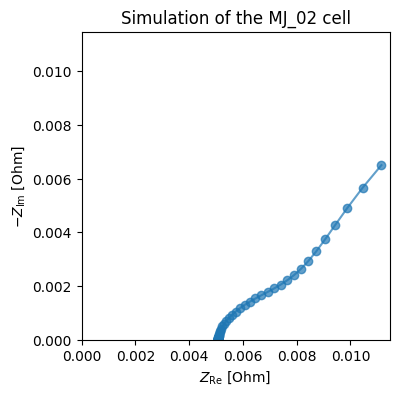

In [11]:
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
#options={"surface form": "differential"}

# Create simulation
eis_sim_func = pybammeis.EISSimulation(model, parameter_values=params)

sim_f_func = eis_sim_func.solve(frequencies, method = "prebicgstab")

# Plotting the simulation (from frequency domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(sim_f_func, ax=ax, linestyle="-", label=f"Simulation by functions", alpha=0.7
    )
#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show()


For plotting specific parameters: 

In [8]:

#sim = pybamm.Simulation(model, parameter_values=params)
#t_eval = np.arange(0, 121, 1)
#sim.solve(t_eval = t_eval)
#print(sim.solution['Positive electrode exchange current density [A.m-2]'].entries)
#sim.plot(['Positive electrode exchange current density [A.m-2]']) 


From ECM: capacity, exchange current density, conductivity and diffusivity as parameters (not functions)

In [12]:
# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))

e_height = params['Electrode height [m]'] #0.059, #params['Electrode height [m]']
e_width = params['Electrode width [m]'] #0.9033043292355315, #params['Electrode width [m]']
e_A = e_height*e_width

s_thick = params['Separator thickness [m]'] #1.0598531461526225e-05, #params['Separator thickness [m]']
anode_thick = params['Negative electrode thickness [m]'] #0.00019850124472796743, #params['Negative electrode thickness [m]']
cathode_thick = params['Positive electrode thickness [m]'] #6.62e-05, #params['Positive electrode thickness [m]']

# Exchange current density from the charge transfer resistance R_ct: 
# For small overpotentials and assuming a symmetrical charge transfer process, 
# i_0 = (R*T)/(n*F*Rct) # From Butler-Volmer! 
#i_0 = (8.314*298)/(1*96485*R_ct) # R_ct from Randles circuit 

# Diffusivity from the Warburg coefficient A: 
# D = ((R*T)/(n*F*area*A))**2
# D = ((8.314*298)/(1*96485*area*A))**2 # A from Randles circuit 

# Conductivity from the charge transfer resistance R_ct: 
# sigma = L/(R*area)
# sigma = thick/(R_ct*e_A) # R_ct from Randles circuit 

# parameters I want to change to optimize the graph: 
p = {
    #Capacity - analog to Cdl/CPE in the Randles circuit 
    'Negative electrode double-layer capacity [F.m-2]': opt_elems.get('Q2')/e_A, #constant or function? 
    'Positive electrode double-layer capacity [F.m-2]': opt_elems.get('Q1')/e_A, #constant or function? 

    #Exchange current density - analog to Rct in the Randles circuit through the Butler-Volmer 
    #"Positive electrode reference exchange-current density [A.m-2]": , #do not think this is needed
    "Positive electrode exchange-current density [A.m-2]": (8.314*298)/(1*96485*opt_elems.get('R_ct1')), #function
    "Negative electrode exchange-current density [A.m-2]": (8.314*298)/(1*96485*opt_elems.get('R_ct2')), #function 

    #Omic resistance - analog to Rel in the Randles circuit? 
    "Electrolyte conductivity [S.m-1]": 1/(s_thick*opt_elems.get('R_el')), #function 
    "Negative electrode conductivity [S.m-1]": anode_thick/(opt_elems.get('R_ct2')*e_A), #function 
    "Positive electrode conductivity [S.m-1]": cathode_thick/(opt_elems.get('R_ct1')*e_A), #function

    #Mass transfer resistance - analog to W in the Randles circuit? 
    "Electrolyte diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*s_thick*opt_elems.get('A2')))**2, #function
    "Negative particle diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*anode_thick*opt_elems.get('A2')))**2,
    "Positive particle diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*cathode_thick*opt_elems.get('A1')))**2  
     }

#print(p)
init_params = dict_to_list(p)
params.update(
    {'Negative electrode double-layer capacity [F.m-2]': init_params[0], 
     'Positive electrode double-layer capacity [F.m-2]': init_params[1], 

     "Positive electrode exchange-current density [A.m-2]": init_params[2], 
     "Negative electrode exchange-current density [A.m-2]": init_params[3], 

     "Electrolyte conductivity [S.m-1]": init_params[4], 
     "Negative electrode conductivity [S.m-1]": init_params[5], 
     "Positive electrode conductivity [S.m-1]": init_params[6], 

     "Electrolyte diffusivity [m2.s-1]": init_params[7],
     "Negative particle diffusivity [m2.s-1]": init_params[8], 
     "Positive particle diffusivity [m2.s-1]": init_params[9]
     })


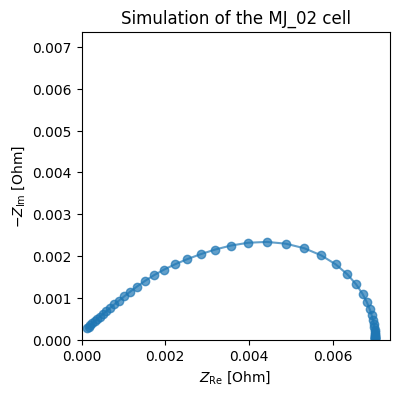

<Figure size 640x480 with 0 Axes>

In [13]:
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
#options={"surface form": "differential"}

# Create simulation
eis_sim_params = pybammeis.EISSimulation(model, parameter_values=params)

sim_f_params = eis_sim_params.solve(frequencies, method = "prebicgstab")

# Plotting the simulation (from frequency domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(sim_f_params, ax=ax, linestyle="-", label=f"Simulation by ECM params", alpha=0.7
    )
#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show()
plt.clf()


PSO on capacity, exchange current density, conductivity and diffusivity as parameters (not functions)

In [14]:


def Z_sim(frequencies, upt_par):
  model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
  params.update(
    {'Negative electrode double-layer capacity [F.m-2]': upt_par[0], 
     'Positive electrode double-layer capacity [F.m-2]': upt_par[1], 

     "Positive electrode exchange-current density [A.m-2]": upt_par[2], 
     "Negative electrode exchange-current density [A.m-2]": upt_par[3], 

     "Electrolyte conductivity [S.m-1]": upt_par[4], 
     "Negative electrode conductivity [S.m-1]": upt_par[5], 
     "Positive electrode conductivity [S.m-1]": upt_par[6], 

     "Electrolyte diffusivity [m2.s-1]": upt_par[7],
     "Negative particle diffusivity [m2.s-1]": upt_par[8], 
     "Positive particle diffusivity [m2.s-1]": upt_par[9]
     })
  eis_sim = pybammeis.EISSimulation(model, parameter_values=params)
  z_sim = eis_sim.solve(frequencies, method = "prebicgstab")
  return z_sim 

real_exp = np.array(df_real)
imag_exp = np.array(df_imag)

def diff_function(upt_par, frequencies, real_exp, imag_exp): 
  imp_sim = Z_sim(frequencies, upt_par)
  real_sim = np.real(imp_sim)
  imag_sim = np.imag(imp_sim)

  real_diff = real_sim - real_exp 
  imag_diff = imag_sim - imag_exp 

  #the total sum of squared differences (magnitude, absolute value, of the complex differences)
  sum_square_diff = np.sum(real_diff**2 + imag_diff**2)
  return sum_square_diff

#print( diff_function(init_params, frequencies, real_exp, imag_exp))

# to pass the additional arguments
# args = (frequencies, real_exp, imag_exp)
def wrapped_diff_function(upt_par):
  return np.array([diff_function(par, frequencies, real_exp, imag_exp) for par in upt_par])

#lower_bounds = [50e-6,5e-6,0.01,0.01, 40e-3, 0] #, -100
#upper_bounds = [300e-6,50e-6,0.2,0.2, 2, 10] #, 100
#bounds = (lower_bounds, upper_bounds)

n_dim = 10 # changing 10 parameters

options = {'c1': 0.5,      # Cognitive parameter (influence of personal best)
    'c2': 0.3,      # Social parameter (influence of global best)
    'w': 0.9,       # Inertia parameter (how much particles retain velocity)
    }

optimizer = ps.single.GlobalBestPSO(n_particles=2, dimensions=n_dim, options=options)  #, bounds=bounds)

best_cost, best_params = optimizer.optimize(wrapped_diff_function, iters=2)

params.update(
    {'Negative electrode double-layer capacity [F.m-2]': best_params[0], 
     'Positive electrode double-layer capacity [F.m-2]': best_params[1], 

     "Positive electrode exchange-current density [A.m-2]": best_params[2], 
     "Negative electrode exchange-current density [A.m-2]": best_params[3], 

     "Electrolyte conductivity [S.m-1]": best_params[4], 
     "Negative electrode conductivity [S.m-1]": best_params[5], 
     "Positive electrode conductivity [S.m-1]": best_params[6], 

     "Electrolyte diffusivity [m2.s-1]": best_params[7],
     "Negative particle diffusivity [m2.s-1]": best_params[8], 
     "Positive particle diffusivity [m2.s-1]": best_params[9]
     })


dic_best_params = list_to_dict(p, best_params)
print("Optimized Parameters:", dic_best_params)
print("Best Cost:", best_cost)


2024-10-15 12:34:10,345 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|2/2, best_cost=0.0134
2024-10-15 12:34:14,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.013443524955335006, best pos: [1.14385342 0.76493076 0.75685402 0.67768708 0.43000437 0.62657955
 1.00037844 0.29808744 0.50588699 1.05195403]


Optimized Parameters: {'Negative electrode double-layer capacity [F.m-2]': 1.1438534153341533, 'Positive electrode double-layer capacity [F.m-2]': 0.7649307599214624, 'Positive electrode exchange-current density [A.m-2]': 0.7568540215458233, 'Negative electrode exchange-current density [A.m-2]': 0.6776870755582889, 'Electrolyte conductivity [S.m-1]': 0.4300043678976333, 'Negative electrode conductivity [S.m-1]': 0.6265795540863306, 'Positive electrode conductivity [S.m-1]': 1.0003784437849954, 'Electrolyte diffusivity [m2.s-1]': 0.2980874434343925, 'Negative particle diffusivity [m2.s-1]': 0.5058869899789777, 'Positive particle diffusivity [m2.s-1]': 1.0519540301650525}
Best Cost: 0.013443524955335006


The general model 

In [15]:
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
#options={"surface form": "differential"}

# Create simulation
eis_sim_pso = pybammeis.EISSimulation(model, parameter_values=params)

#model.print_parameter_info()


Model solved in the frequency domain (with prebicgstab method)

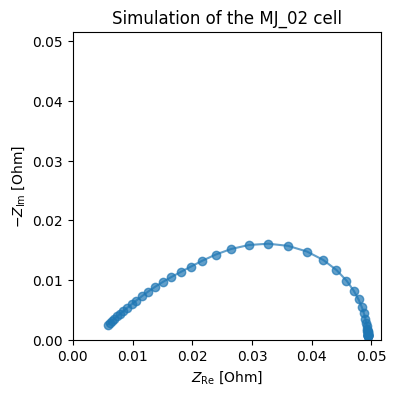

In [16]:
sim_f_pso = eis_sim_pso.solve(frequencies, method = "prebicgstab")

# Plotting the simulation (from frequency domain)
fig, ax = plt.subplots(figsize=(4, 4)) 
pybammeis.nyquist_plot(sim_f_pso, ax=ax, linestyle="-", label=f"Simulation with PSO", alpha=0.7
    )

#ax.set_xlim(0.0475, 0.0550) 
#ax.set_ylim(0, 0.008)

#plt.legend()
plt.title('Simulation of the MJ_02 cell')
plt.show() 

Comparing the experimental and the simulated EIS

(and also the ECM model)

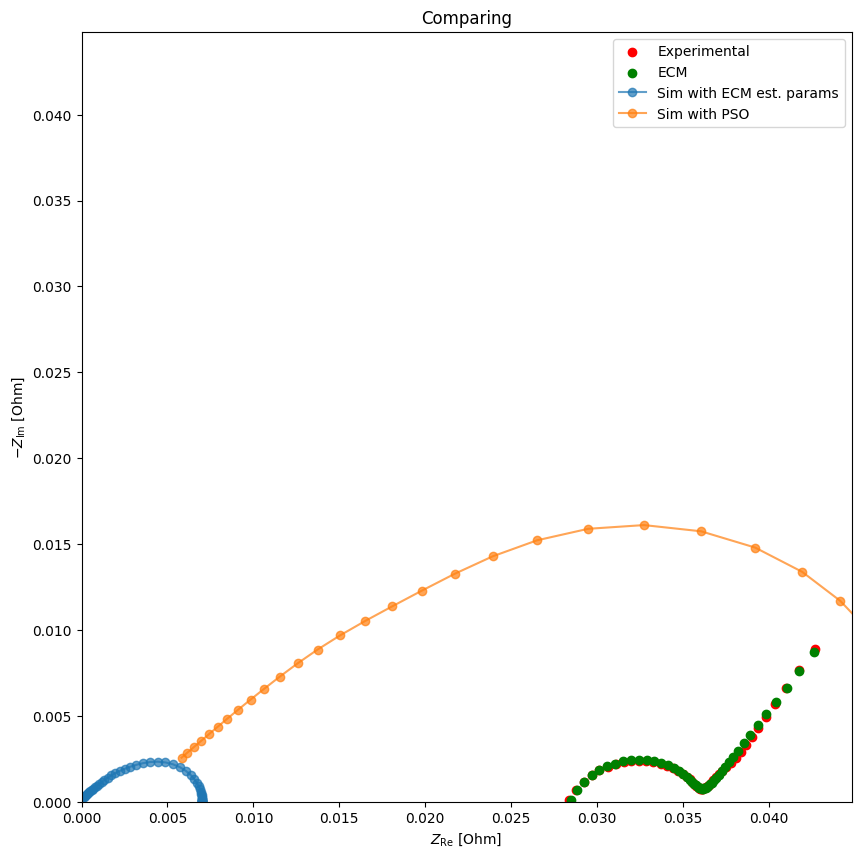

In [19]:
names = ['Experimental', 'Simulation']

fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(df_real, -df_imag, label=f"Experimental", color = 'red') 
ax.scatter(Z_randles().real, -Z_randles().imag, label = f'ECM', color = 'green')
#pybammeis.nyquist_plot(sim_f_func, ax=ax, linestyle="-", label=f"Sim with functions", alpha=0.7)
pybammeis.nyquist_plot(sim_f_params, ax=ax, linestyle="-", label=f"Sim with ECM est. params", alpha=0.7)
pybammeis.nyquist_plot(sim_f_pso, ax=ax, linestyle="-", label=f"Sim with PSO", alpha=0.7)

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

Bode plot for the experimental and simulated EIS

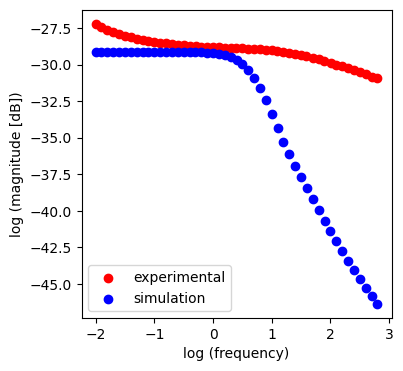

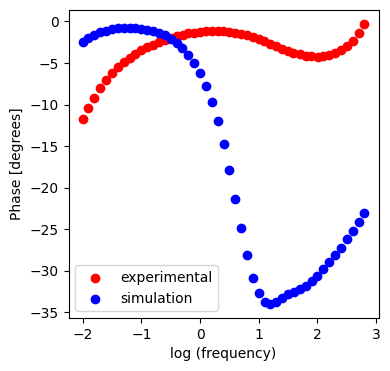

In [13]:
# Magnitude and phase of the simulated EIS: 
sim_f_mag = np.abs(sim_f)

sim_f_phz = np.angle(sim_f)*180/np.pi # to convert to degrees 

# Magnitude plot
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(np.log10(freq), 20*np.log10(df_mag), color = 'red', label = 'experimental') 
ax.scatter(np.log10(frequencies), 20*np.log10(sim_f_mag), color = 'blue', label = 'simulation') 
ax.set_xlabel('log (frequency)')
ax.set_ylabel('log (magnitude [dB])')
plt.legend()
plt.show() 

# Phase plot
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(np.log10(freq), df_phz, color = 'red', label = 'experimental')
ax.scatter(np.log10(frequencies), sim_f_phz, color = 'blue', label = 'simulation')
ax.set_xlabel('log (frequency)')
ax.set_ylabel('Phase [degrees]')
plt.legend()
plt.show() 
